# Imports

In [2]:
# imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import gc, joblib

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## import data

In [3]:
def import_data(seq_length):
    matrix_array = np.load(f'Data/matrix_array_{seq_length}_normalized.npy')
    answer_array = np.load(f'Data/answer_array_{seq_length}.npy')

    X = matrix_array
    y = answer_array

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, random_state=1, stratify=y)

    X_test_flattened = np.array([x.flatten() for x in X_test])

    y_test_transformed = np.array([1 if np.argmax(y) == 0 else (0 if np.argmax(y) == 2 else -1) for y in y_test])
    # answer = chunk.iloc[i+19][['plus_6', 'minus_6', 'zero_6']].tolist()
    # zero = 0, up = 1, down = -1
    y_test_transformed012 = np.array([1 if np.argmax(y) == 0 else (0 if np.argmax(y) == 2 else 2) for y in y_test])
    # 1 = up , 2 = down, 0 = zero

    del X, y, X_train, X_test, y_train, y_test, matrix_array, answer_array
    gc.collect()

    return X_test_flattened, y_test_transformed, y_test_transformed012


## test models

In [4]:
def test_model(model_name, seq_length):
    X_test_flattened, y_test_transformed, y_test_transformed012 = import_data(seq_length)
    print(f'import {seq_length} Data Done')

    if model_name == 'XGB':
        y_test_transformed = y_test_transformed012
        
    model = joblib.load(f'Models/{model_name}_model_{seq_length}.pkl')
    print(f'import {model_name} model Done')

    y_pred = model.predict(X_test_flattened)
    print('prediction Done')

    print(np.unique(y_pred))

    # Calculate accuracy
    accuracy = accuracy_score(y_test_transformed, y_pred)
    print(f"Accuracy: {accuracy}")

    # Print classification report
    report = classification_report(y_test_transformed, y_pred)
    print("Classification Report:")
    print(report)

    # Calculate the confusion matrix
    cm = confusion_matrix(y_test_transformed, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot the normalized confusion matrix
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues')
    plt.title(f'{model_name}_{seq_length} Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.savefig(f'Figures/{model_name}_{seq_length}_Counfusion_Matrix.png')
    plt.show()

    # accuracy?
    wrong_count = cm[0][1]+cm[0][2] + cm[1][0]+cm[1][2] + cm[2][0]+cm[2][1]
    correct_count = cm[0][0] + cm[1][1] + cm[2][2]

    print(f'wrong count : {wrong_count}, correct count : {correct_count}')
    print(f'accuracy? : {100*correct_count/(wrong_count+correct_count)}') 
    '''
    data = pd.read_csv('Data/df_all.csv')
    data = data.drop(['Open time', 'Close time', 'Ignore','up_cross','down_cross','minutes','log_minutes','side','plus_6','minus_6','zero_6'], axis=1)
    print(data.columns)

    # Rename columns
    new_columns = []
    for i in range(seq_length):  # for each time step
        new_columns.extend([f"{col}_{i}" for col in ['Open', 'High', 'Low', 'Close', 'Volume', 'Quote asset volume', 'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume','MA5','MA10','MA20','MA30','MA60','MA120','MA240', 'BB0','BB+','BB-' ]])

    # Get feature importances
    importances = model.feature_importances_
    # Convert to a DataFrame
    feature_importance_df = pd.DataFrame({'Feature': new_columns, 'Importance': importances})

    # Sort by importance
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Plot feature importances
    feature_importance_df.plot(kind='bar', x='Feature', y='Importance')
    plt.title('Feature Importances')
    plt.ylabel('Importance')
    plt.show()

    # Display the top N features in a bar chart
    top_n = 20  # You can adjust this number
    top_features = feature_importance_df.head(top_n)
    top_features.plot(kind='bar', x='Feature', y='Importance', figsize=(10, 6))
    plt.title('Top Feature Importances')
    plt.ylabel('Importance')
    plt.show()

    # Print the sorted list of features and their importances
    print("Sorted Feature Importances:")
    print(feature_importance_df.to_string(index=False))

    # Assuming importances and new_columns are defined
    feature_importance_df = pd.DataFrame({'Feature': new_columns, 'Importance': importances})

    # Split the feature names and aggregate importances
    feature_importance_df['BaseFeature'] = feature_importance_df['Feature'].apply(lambda x: x.split('_')[0])
    aggregated_importances = feature_importance_df.groupby('BaseFeature')['Importance'].sum()

    # Sort by importance
    aggregated_importances = aggregated_importances.sort_values(ascending=False)

    # Plot aggregated feature importances
    aggregated_importances.head(20).plot(kind='bar', figsize=(10, 6))
    plt.title('Aggregated Feature Importances')
    plt.ylabel('Importance')
    plt.show()

    # Print the sorted list of aggregated features and their importances
    print("Sorted Aggregated Feature Importances:")
    print(aggregated_importances.to_string())
    '''

## predictions

import 20 Data Done
import RFC model Done


[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.


prediction Done
[-1  0  1]
Accuracy: 0.6751027194679371
Classification Report:
              precision    recall  f1-score   support

          -1       0.62      0.41      0.49     15546
           0       0.70      0.92      0.80     32835
           1       0.63      0.38      0.48     14168

    accuracy                           0.68     62549
   macro avg       0.65      0.57      0.59     62549
weighted avg       0.66      0.68      0.65     62549



[Parallel(n_jobs=28)]: Done 100 out of 100 | elapsed:    0.2s finished


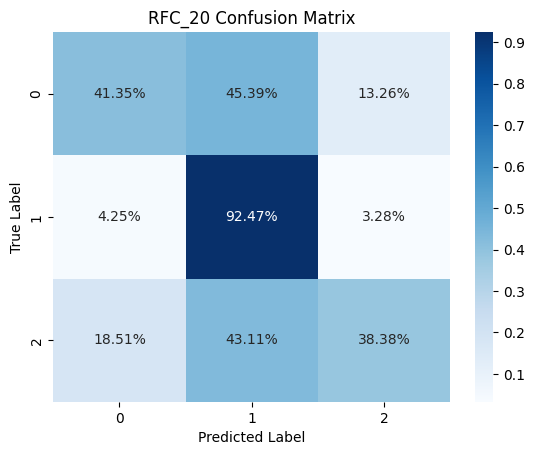

wrong count : 20322, correct count : 42227
accuracy? : 67.51027194679371


In [5]:
seq_lengths = [20,40,60,80]
models = [
    'RFC', 
    'XGB',
    ]

for seq_length in seq_lengths:
    for model_name in models:
        test_model(model_name, seq_length)